In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
from dataclasses import dataclass, field, replace
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

In [ ]:
import RaTag.dataIO as dataIO 
from RaTag.datatypes import *
import RaTag.config as config
import RaTag.transport as transport
import RaTag.plotting as plotting
import RaTag.constructors as constructors
import RaTag.analysis as analysis
import RaTag.transformations as transf
from RaTag.xray_integration import *

In [4]:
base_dir = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec')

# Test x-rays module

In [5]:
file_ff = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN8_20250903_Gate500_Anode2400_P6_1Wfm.wfm'
wfm_ff = dataIO.load_wfm(file_ff)
wfm_ff.ff

True

In [6]:
base_dir = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec')
meas_path = base_dir / 'FieldScan_5GSsec_Anode1950V_Gate50V'
# look into wfm 7319
wfm_paths = sorted(meas_path.glob('*.wfm'))
wfy = dataIO.load_wfm(wfm_paths[95])
wfn = dataIO.load_wfm(wfm_paths[96])
wfyy = dataIO.load_wfm(wfm_paths[310])
wfnn = dataIO.load_wfm(wfm_paths[311])
wfy3 = dataIO.load_wfm(wfm_paths[7333])
i = 0

In [7]:
i

0

In [8]:
t_s1 = -3.2
s2_start = 15
i += 1
wfn3 = dataIO.load_wfm(wfm_paths[7330 + i])
fig, ax = plt.subplots(3, 2, figsize=(12, 8), )
plotting.plot_waveform(wfy, ax=ax[0,0], title='Accepted X-ray')
plotting.plot_waveform(wfn, ax=ax[0,1], title='Rejected: excessive S2 check')
plotting.plot_waveform(wfyy, ax=ax[1,0], title='Accepted X-ray')
plotting.plot_waveform(wfnn, ax=ax[1,1], title='Rejected: separation check')
plotting.plot_waveform(wfy3, ax=ax[2,0], title='Accepted X-ray')
plotting.plot_waveform(wfn3, ax=ax[2,1], title='Rejected: excessive S2 check')
for a in ax.flatten():
    a.axvline(t_s1, color='C1', ls='--', lw=1)
    a.axvline(s2_start, color='C2', ls='--', lw=1)
plt.tight_layout()

Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability


In [40]:
xres_test = []
for wf in [wfy, wfn, wfyy, wfnn, wfy3, wfn3]:
    xre = xray_event_pipeline(wf, t_s1=t_s1, s2_start=s2_start, bs_threshold=2, max_area_s2=1e5,
                              dt = 2e-4, min_s2_sep=1, min_s1_sep=1)
    # print(xre.wf_id, xre.accepted, xre.reason)
    xres_test.append(xre)

# plotting.plot_waveform(pwf, title='Processed accepted X-ray')

In [55]:
xres_test[0].wf_id, xres_test[0].area

('RUN5_26052025_Gate50_Anode1950_P7_1086Wfm', array([7.56128774]))

In [10]:
E_daughter = 4/224*5680
N_exp = E_daughter * 1000 /22
139 / N_exp

0.030149295774647887

In [3]:
W = 22  # eV
E_gamma = 12.3 * 1000  # eV, from https://www.nndc.bnl.gov/nudat3/decaysearchdirect.jsp?nuc=232Th&unc=NDS
N_e = E_gamma / W 
N_e

559.0909090909091

In [5]:
1/0.00716675375393 * 22

3069.7301393864636

# Test at set level

In [44]:
set_50 = constructors.set_from_dir(meas_path)

In [46]:
xres50 = classify_xrays_set(set_50, t_s1=t_s1, s2_start=s2_start, bs_threshold=2, max_area_s2=1e5,
                        min_s2_sep=1, min_s1_sep=1, dt=2e-4)

In [47]:
xareas = np.array([xr.area  for xr in xres50.events if xr.accepted])

In [57]:
for xr in xres50.events:
    if xr.wf_id == 'RUN5_26052025_Gate50_Anode1950_P7_1086Wfm':
        print(xr.wf_id, xr.accepted, xr.reason, xr.area)

RUN5_26052025_Gate50_Anode1950_P7_1086Wfm True ok [7.56128774]


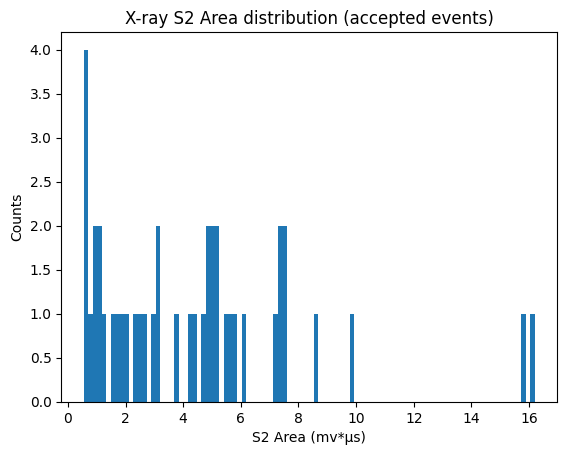

In [60]:
from matplotlib.pyplot import xlabel


xcut = xareas[(xareas > 0.5) & (xareas < 30)]
plt.hist(xcut, bins=100);
plt.gca().set(xlabel='S2 Area (mv*µs)', ylabel='Counts', title='X-ray S2 Area distribution (accepted events)');

In [28]:
np.mean(xcut) * 1000 # / 23.6  # phe/keV


np.float64(60.837309873702544)

# Test at run level

In [16]:
run5 = Run(
    root_directory = base_dir,
    run_id = "RUN5",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 1e9,
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm

    width_s2 = 20                # µs 
)

run5 = constructors.populate_run(run5)
run5 = transport.with_gas_density(run5)

run5.gas_density

4.877421222922505e+19

In [17]:
def prepare_set(s: SetPmt, run: Run) -> SetPmt:
    s1 = constructors.estimate_s1_from_batches(s, n_batches=20, batch_size=20, flag_plot=False)
    s1 = constructors.set_fields(s1, drift_gap_cm=run.drift_gap, el_gap_cm=run.el_gap, gas_density=run.gas_density)
    s1 = constructors.set_transport_properties(s1, drift_gap_cm=run.drift_gap, transport=None)
    return s1

run5 = replace(run5, sets=[prepare_set(s, run5) for s in run5.sets])

In [18]:
for set in run5.sets:
    if set.metadata['t_s1'] < -3.7:
        set.metadata['t_s1'] = -3.2

In [19]:
intconfig_xrays = config.IntegrationConfig(
    bs_threshold = 2,          # mV
    max_area_s2 = 1e5,        # mV·µs
    min_s2_sep = 1,            # µs
    min_s1_sep = 1,            # µs
    n_pedestal = 200,          # samples
    ma_window = 10,            # samples
    dt = 2e-4,                    # ns
)
results_run5 = classify_xrays_run(run5, ts2_tol = -0.2, 
                                          config=intconfig_xrays)

Processing x-rays in set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V in drift window: (-3.2, np.float64(16.5755956679796))
Processing x-rays in set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V in drift window: (np.float64(-3.282), np.float64(11.655548167034853))
Processing x-rays in set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2100V_Gate200V in drift window: (-3.2, np.float64(9.80980081794834))
Processing x-rays in set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2500V_Gate600V in drift window: (-3.2, np.float64(7.50498318913292))
Processing x-rays in set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode3000V_Gate1100V in drift window: (-3.2, np.float64(6.037556890966933))
Processi

In [20]:
results_run5

{'FieldScan_5GSsec_Anode1950V_Gate50V': XRayResults(set_id=PosixPath('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V'), events=[XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_1245Wfm', accepted=False, reason='no signal above baseline', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_1514Wfm', accepted=False, reason='insufficient separation (t_pre_s2=19.76), (t_post_s1=0.01)', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_4659Wfm', accepted=False, reason='no signal above baseline', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_7900Wfm', accepted=False, reason='insufficient separation (t_pre_s2=0.00), (t_post_s1=19.77)', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_4108Wfm', accepted=False, reason='insufficient separation (t_pre_s2=0.18), (t_post_s1=19.59)', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_8962Wfm', accepted=True, reason

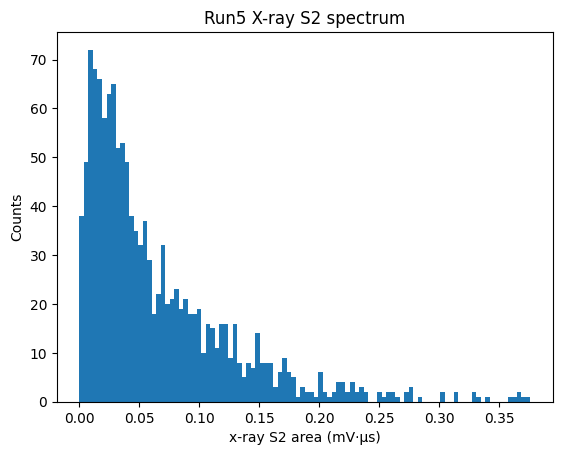

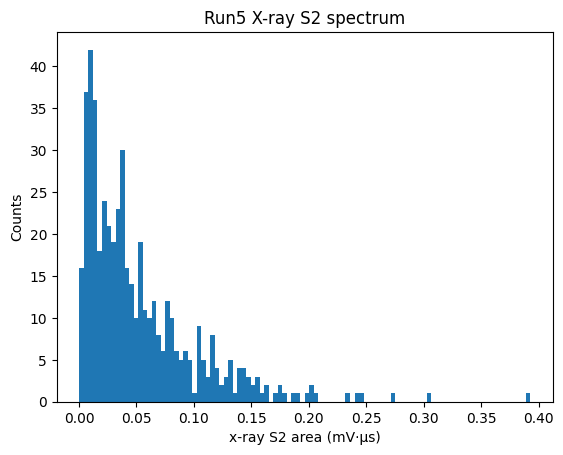

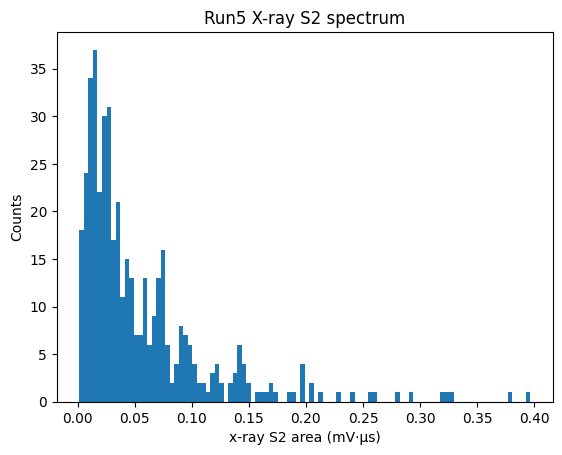

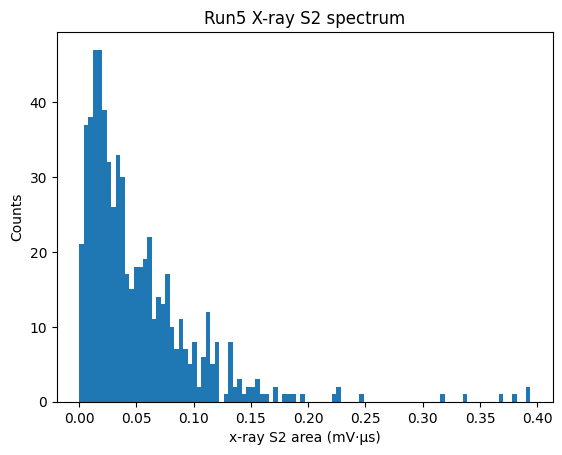

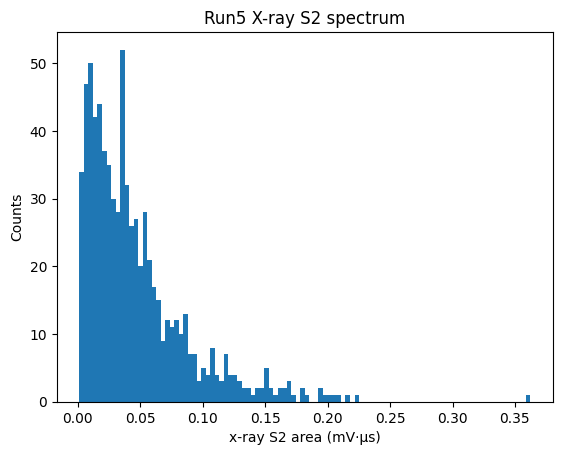

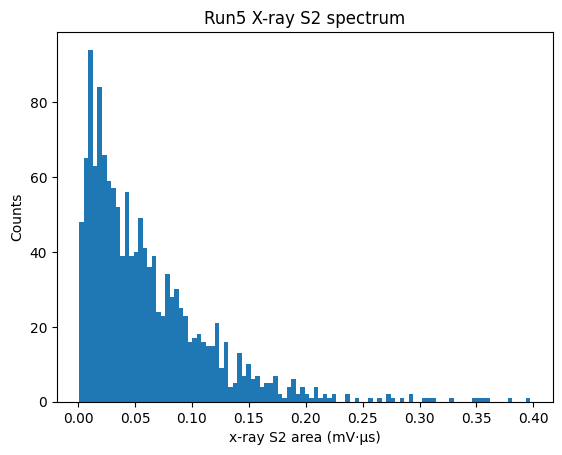

/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_26115/1750048622.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


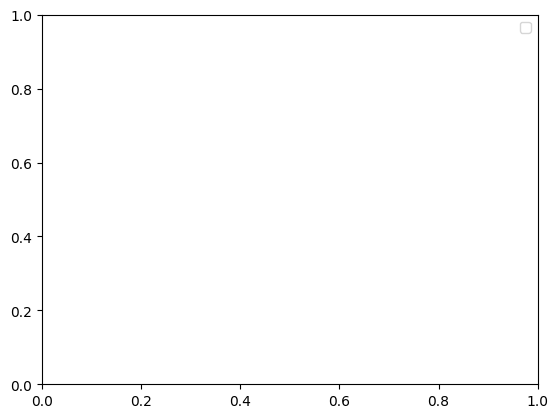

In [21]:
from matplotlib.pyplot import xlabel


for set_id, xr in results_run5.items():
    xareas = np.array([xr.area for xr in xr.events if xr.accepted])
    xcut = xareas[xareas < 0.4]
    plt.hist(xcut, bins=100, label=set_id);
    plt.gca().set(xlabel='x-ray S2 area (mV·µs)', ylabel='Counts', title='Run5 X-ray S2 spectrum');
    plt.show() 
plt.legend()